In [1]:
import pandas as pd 
import os
import math
import random

import numpy as np
from scipy import optimize, signal

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import compress

In [2]:
from lmfit import models

### 1. Fit curve 

-----

tutorial from : 
https://chrisostrouchov.com/post/peak_fit_xrd_python/

gaussian function 

$f(x;A,\mu ,\sigma) = \frac{A}{\sigma \sqrt{2\pi}} e^{[{-(x-\sigma)^2/2\sigma^2}]}$

In [3]:
def g(x, A, mu, sigma):
    return A / (sigma * np.sqrt(2*np.pi)) * np.exp((-(x-mu)**2)/(2*sigma**2))

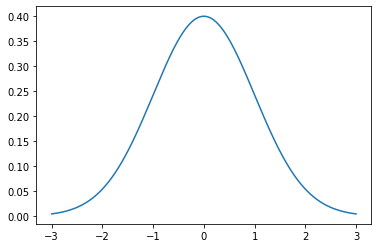

In [4]:
x = np.linspace(-3,3,1000)

y = g(x, 1, 0 ,1)

plt.plot(x,y)

Optimization of some $f(x)$

In [5]:
def f(x):
    return np.exp(-(x-2)**2) + np.exp(-(x-6)**2/10) + 1/(x**2 + 1)

x = np.linspace(-2, 10, 1000)
y = -f(x)

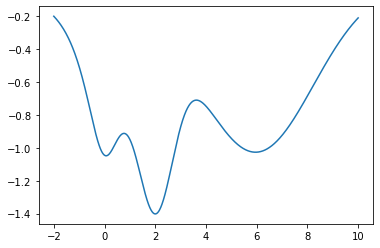

In [6]:
plt.plot(x,y)

In [7]:
res = optimize.minimize(lambda x: -f(x), x0=20, method='Nelder-Mead')

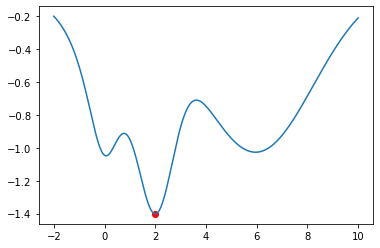

In [8]:
plt.plot(x,y)
plt.scatter(res.x, -f(res.x),c='r')

Adding noise to gaussian 

In [9]:
A=100
mu = 4
sigma = 4
n = 200

x = np.linspace(-10,10,n)
y = g(x, A, mu, sigma) + np.random.normal(0,1,n)

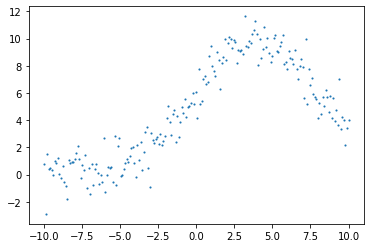

In [10]:
plt.scatter(x,y, s=1.2)

Minimize error

$MSE = \frac{1}{n} \sum_{i=1}^{n}(Y_i-\hat{Y}_i)^2$

In [11]:
def mse(params, x, y_hat):
    """
    Minimize MSE for y and y_hat
    """
    y = g(x,*params)
    return 1/len(y) * np.sum((y-y_hat)**2)

result = optimize.minimize(mse,
                           x0=[0,0,1],
                           args=(x,y), 
                           method='Nelder-Mead')

In [12]:
result = optimize.minimize(mse,
                           x0=[10,0,1],
                           args=(x,y), 
                           method='Nelder-Mead')
print('steps', result.nit, result.fun)
print(f'amplitude: {result.x[0]:3.3f} mean: {result.x[1]:3.3f} sigma: {result.x[2]:3.3f}')

steps 138 0.9753279573758473
amplitude: 99.163 mean: 3.991 sigma: 3.991


In [13]:
result

 final_simplex: (array([[99.16326386,  3.99100692,  3.99094084],
       [99.16316533,  3.9910018 ,  3.99093627],
       [99.16329615,  3.99099408,  3.99093988],
       [99.16324511,  3.99099956,  3.99093075]]), array([0.97532796, 0.97532796, 0.97532796, 0.97532796]))
           fun: 0.9753279573758473
       message: 'Optimization terminated successfully.'
          nfev: 250
           nit: 138
        status: 0
       success: True
             x: array([99.16326386,  3.99100692,  3.99094084])

In [14]:
result = optimize.minimize(mse,
                           x0=[0,0,1],
                           args=(x,y), 
                           method='SLSQP')
print('steps', result.nit, result.fun)
print(f'amplitude: {result.x[0]:3.3f} mean: {result.x[1]:3.3f} sigma: {result.x[2]:3.3f}')

steps 14 0.975328016569171
amplitude: 99.162 mean: 3.991 sigma: 3.991


In [15]:
y_opt = g(x, *result.x)


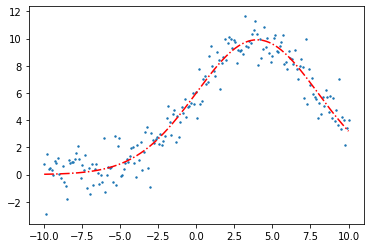

In [16]:
plt.scatter(x,y,s=2)
plt.plot(x,y_opt, '-.r')

fit two gaussian models

In [17]:
g_0 = [250.0, 4.0, 5.0]
g_1 = [20.0, -5.0, 1.0]
n = 150
x = np.linspace(-10, 10, n)

y = g(x, *g_0) + g(x, *g_1) + np.random.randn(n)

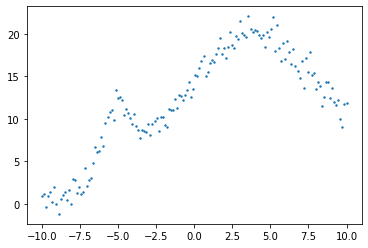

In [18]:
plt.scatter(x,y,s=2)

In [19]:
def mse(params, x, y_hat):
    y_1 = g(x,*params[:3])
    y_2 = g(x,*params[3:])
    return 1/len(y) * np.sum(((y_1+y_2)-y_hat)**2)


result = optimize.minimize(mse, x0=[1, 0, 1, -1, 0, 1],args=(x,y))

In [20]:
print('steps', result.nit, result.fun)
print(f'g_0: amplitude: {result.x[0]:3.3f} mean: {result.x[1]:3.3f} sigma: {result.x[2]:3.3f}')
print(f'g_1: amplitude: {result.x[3]:3.3f} mean: {result.x[4]:3.3f} sigma: {result.x[5]:3.3f}')



steps 61 0.9793366246433276
g_0: amplitude: 18.724 mean: -5.137 sigma: 0.948
g_1: amplitude: 254.822 mean: 3.984 sigma: 5.096


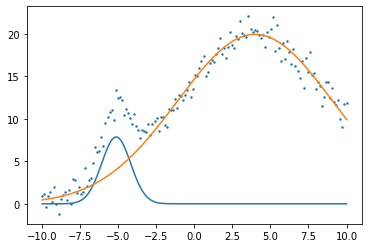

In [21]:
y_1 = g(x, *result.x[:3])
y_2 = g(x, *result.x[3:])
plt.scatter(x,y,s=2)
plt.plot(x,y_1)
plt.plot(x,y_2)

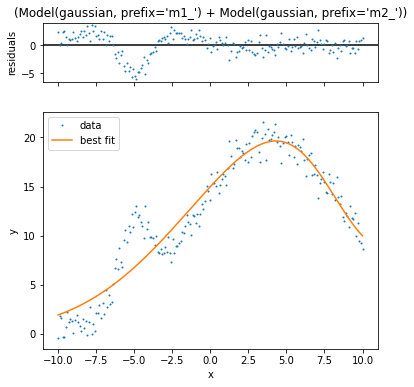

In [22]:
g_0 = [250.0, 4.0, 5.0]
g_1 = [20.0, -5.0, 1.0]
n = 200
x = np.linspace(-10, 10, n)

y = g(x, *g_0) + g(x, *g_1) + np.random.randn(n)

model_1 = models.GaussianModel(prefix='m1_')
model_2 = models.GaussianModel(prefix='m2_')
model = model_1 + model_2

params_1 = model_1.make_params(center=1, sigma=1)
params_2 = model_2.make_params(center=-2, sigma=1)
params = params_1.update(params_2)

output = model.fit(y, params, x=x)
fig = output.plot(data_kws={'markersize': 1})



### 2. Read dataset of XRD

In [23]:
dirname = '../data/QSAR_XRD/'
files = os.listdir(dirname)

# read UXD
fname = os.path.join(dirname, files[0])
with open(fname, 'rb') as file:
    data = file.readlines()

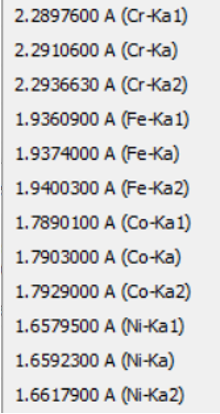

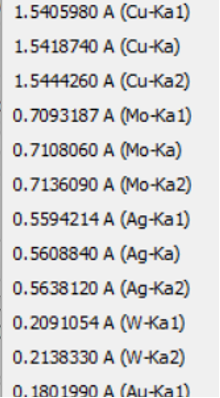


In [ ]:
source_dict = {"Cr": 2.2897600, }

In [287]:
class XRD_parser:
    """
    Parser of XRD data based on fname 
    """
    def __init__(self):
        self.get_extension = lambda x: os.path.splitext(x)[-1]
        self.availabel_extensions = {'.UXD', '.dat', '.txt', '.xyd'}
        self.source_name = None
        self.max_theta = None
    def _is_float(self, element: any)-> bool:
        try:
            element = element.decode('utf-8').strip().split()[0]
        except:
            return False
        if element is None:
            return False
        try: 
            float(element)
            return True
        except ValueError:
            return False
    def get_source_name(self, fname: str, data: list, xrd_data: list)->list:
        
        
        
        sources = ['CU', "Cu", "Cr", "CR", "Co"]
        matches = [x for x in sources if x in fname]
        
        # Шаг 1
        if len(matches)>0:
            return matches
        with open(fname, 'rb') as file:
            data = file.readlines()
        for line in data:
            matches = [x for x in sources if x in str(line)]
            if len(matches)>0:
                return matches
            
        if xrd_data[-1][0]>85:
            matches = ['Cr']
        else:
            matches = ['Cu']
        return matches
    def _convert_to_float(self, element:str)->list:
        try:
            element = element.decode('utf-8').strip().split()
            return [float(value) for value in element ]
        except ValueError:
            return []
        
    
    def parse(self, fname:str)->list:
        with open(fname, 'rb') as file:
            data = file.readlines()
        mask = list(map(self._is_float, data))
        selection = list(compress(data, mask))
        xrd_data = list(map(self._convert_to_float, selection))
        
        source_name = self.get_source_name(fname=fname, data=data, xrd_data=xrd_data)
        self.source_name = source_name
        self.max_theta = xrd_data[-1][0]
        return xrd_data
    
    def plot(self, data: list, prominence:int, distance:int=20, width:int=20):
        df = pd.DataFrame(data)
        df = df.iloc[:, :2]
        df.columns = ['x','y']
        df.loc[:, 'normilized'] = (df.y - df.y.min()) / (df.y.max() - df.y.min())
        df.loc[:, 'savgol'] = signal.savgol_filter(df['normilized'], 15,2) # 15 and 1 parameters
#         mask = df['x']>40
#         df = df.loc[mask]
        x = df['savgol'].values
        peaks, _ = find_peaks(x, prominence=prominence, width=width, distance=distance)
        
        plt.plot(df["x"].values[peaks], df.savgol.values[peaks], "ob")
        plt.plot(df.x.values, df.savgol.values) 
#         plt.plot(peaks, x[peaks], "ob")
#         plt.plot(x) 
        plt.legend(['prominence'])

#         for i, peak in enumerate(peaks):
#             degree = df['x'].values[peak]
#             plt.annotate(round(degree, 2), (peak+50, x[peak]))
        plt.title(self.source_name[0])
        plt.show()
        return df
        # Как найти градус для последнего пика? 


In [288]:
parser = XRD_parser()

In [289]:
test_fnames = ['Fe3O4 FeCl2 Cu.dat', 'Fe3O4-HA 80 Cr_Юр.dat']

In [290]:
files_ = [
 'Fe3O4-AC in situ Cr.dat',
 'Fe3O4_Cu_Zah.dat',
 'Fe-кирг-6.UXD',
 'Fe3O4-AC ex situ Cr.dat',
 'Fe3O4 Cr Юрищева.dat',
 'Fe3O4-TEOS-APTES.dat',
 'CT-Fe3O4-MOF-LB5_R01.xyd',
 'Fe2O3 okisl_170221112959.txt',
 'KA_Fe3O4_170127130924.txt',
 'Fe3O4-HA 50 Cr Юр.dat',
 'Fe3O4-HA 80 Cr_Юр.dat',
 'Fe3O4_Pec5_Cu_Zah.dat',
 'Fe3O4-HA50 M30 Cr Юр.dat',]

## Условия

1. Второй пик самый большой
2. Пики 4<5<6
3. Если все пики меньше 30-35 и начало с 10 - то молибден 

Fe3O4-AC in situ Cr.dat


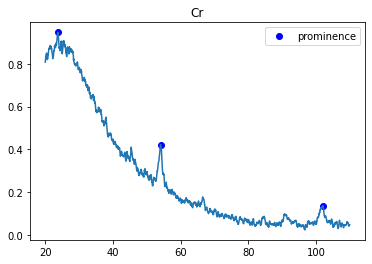

Fe3O4_Cu_Zah.dat


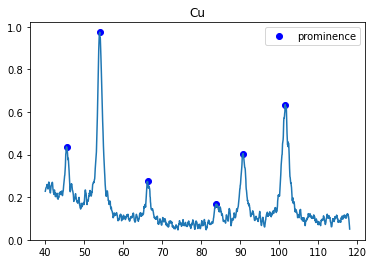

Fe-кирг-6.UXD


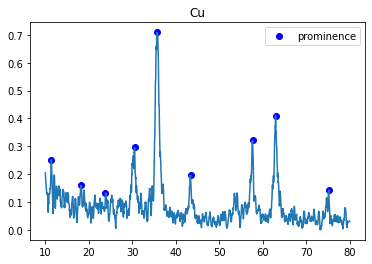

Fe3O4-AC ex situ Cr.dat


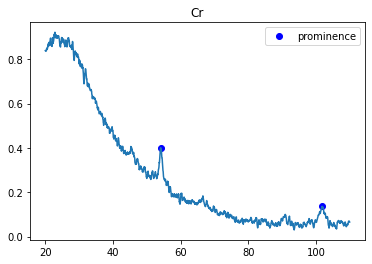

Fe3O4 Cr Юрищева.dat


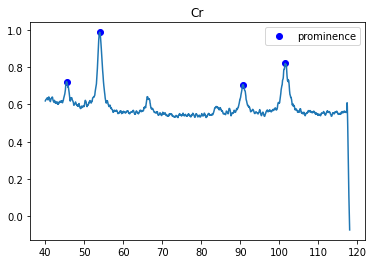

Fe3O4-TEOS-APTES.dat


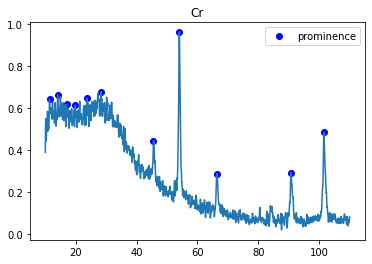

CT-Fe3O4-MOF-LB5_R01.xyd


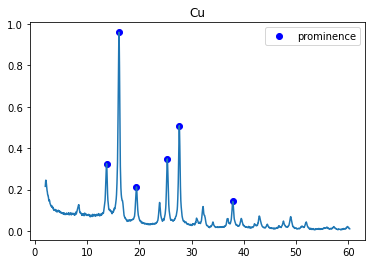

Fe2O3 okisl_170221112959.txt


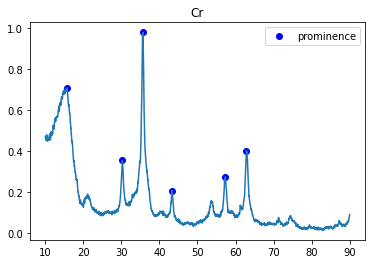

KA_Fe3O4_170127130924.txt


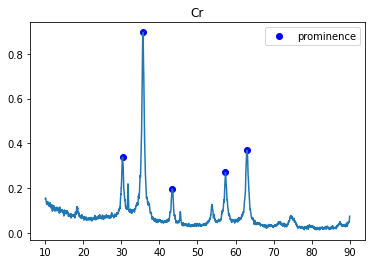

Fe3O4-HA 50 Cr Юр.dat


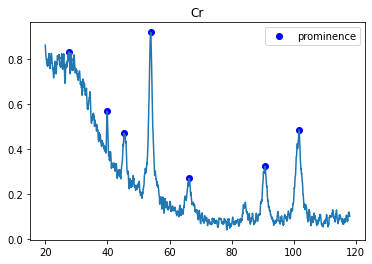

Fe3O4-HA 80 Cr_Юр.dat


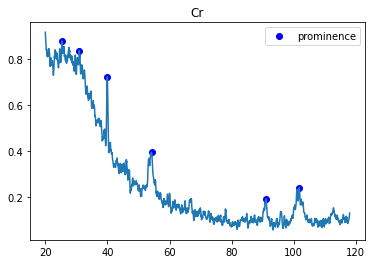

Fe3O4_Pec5_Cu_Zah.dat


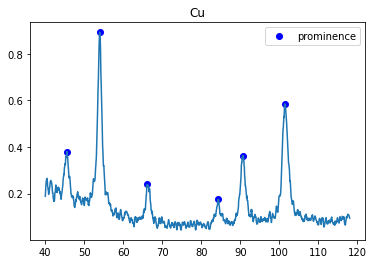

Fe3O4-HA50 M30 Cr Юр.dat


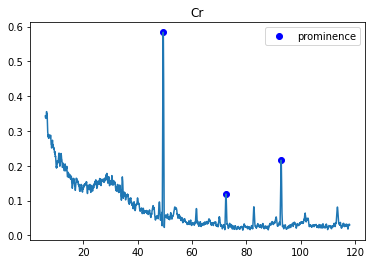

In [293]:

for file in files_:
    print(file)
    fname = os.path.join(dirname, file)
    data = parser.parse(fname=fname)
    df = parser.plot(data=data,
                     prominence=0.1,
                     distance=100, 
                     width=5)
    
    
    plt.show()
#     break

In [276]:
# from scipy.signal import savgol_filter, find_peaks_cwt
# window =15
# minn=0
# maxn = len(df)
# data = df['y']
# # (len1,w1)= np.shape(data)
# w1=1
# nexp1 =np.zeros([maxn-minn,w1])
# # new1 = savgol_filter(data[minn:maxn,i], 31, 3)
# new1 = signal.savgol_filter(data, 31, 3)
# #peak finding
# zf= find_peaks_cwt(new1, np.arange(10,15), noise_perc=0.01)
# #background substraction
# for j in range(len(zf)-1):
#     zf_start= np.maximum(0,zf[j+1]-window//2)
#     zf_end = np.minimum(zf[j+1]+window//2,maxn)
#     peak = new1[zf_start:zf_end]

# ##abritaryly remove 1/4 data
# npeak = np.maximum(0,peak-max(np.partition(peak,window//5 )[0:window//5]))
# nexp1[zf_start:zf_end,i]= npeak

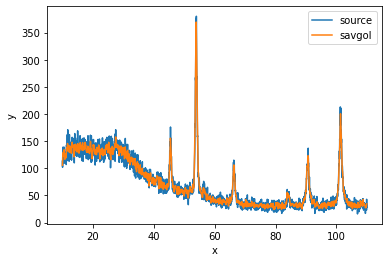

In [277]:
file = files[-2]
fname = os.path.join(dirname, file)
data = parser.parse(fname=fname)
df = pd.DataFrame(data )
df = df.iloc[:, :2]
df.columns = ['x','y']
df.loc[:, 'savgol'] = signal.savgol_filter(df.y, 15,2) # 15 and 1 parameters

sns.lineplot(x='x', y='y', data=df, label = 'source')
sns.lineplot(x='x', y='savgol', data=df, label='savgol')
plt.legend()

### 2. Plot XRD data

## Попробовать SciPy find peaks 

In [31]:
from scipy.signal import find_peaks

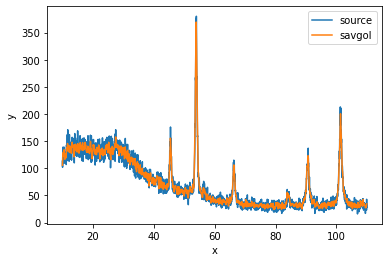

In [35]:

sns.lineplot(x='x', y='y', data=df, label = 'source')
sns.lineplot(x='x', y='savgol', data=df, label='savgol')
plt.legend()

In [36]:
x = df['savgol']
peaks, _ = find_peaks(x, distance=20)
peaks2, _ = find_peaks(x, prominence=1)      # BEST!
peaks3, _ = find_peaks(x, width=20)
peaks4, _ = find_peaks(x, threshold=0.4)     # Required vertical distance to its direct neighbouring samples, pretty useless

In [75]:
peaks

array([  77,  219,  557, 1053, 1754, 2029, 2455])

In [227]:
x[peaks]

array([ 83.57782805, 155.47330317, 369.37149321, 106.23348416,
        55.88868778, 123.28959276, 200.47013575])

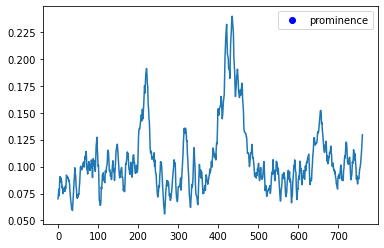

In [230]:
df = df.loc[mask]
x = df['savgol'].values
peaks, _ = find_peaks(x, prominence=20)
plt.plot(peaks, x[peaks], "ob")
plt.plot(x) 
plt.legend(['prominence'])


for i, peak in enumerate(peaks):
    degree = df['x'].values[peak]
    plt.annotate(round(degree, 2), (peak+50, x[peak]))
    
plt.show()

In [233]:
peaks

array([  77,  219,  557, 1053, 1754, 2029, 2455])

In [260]:
degree

101.35

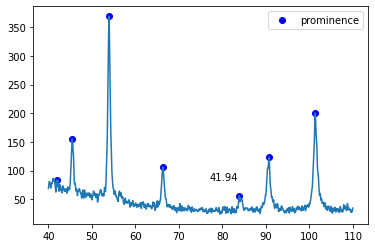

Положение последнего пика в градусах: 101.35


In [266]:
file = files[-2]
fname = os.path.join(dirname, file)
data = parser.parse(fname=fname)
df = pd.DataFrame(data )
df = df.iloc[:, :2]
df.columns = ['x','y']
df.loc[:, 'savgol'] = signal.savgol_filter(df.y, 15,2) # 15 and 1 parameters
mask = df['x']>40
df = df.loc[mask]
x = df['savgol'].values
peaks, _ = find_peaks(x, prominence=20, distance=5, width=10)
plt.plot(df["x"].values[peaks], df.savgol.values[peaks], "ob")
plt.plot(df.x.values, df.savgol.values) 
plt.legend(['prominence'])

for i, peak in enumerate(peaks):
    degree = df['x'].values[peak]
    plt.annotate(round(degree, 2), (peak, x[peak]))

plt.show()
# Как найти градус для последнего пика? 

degree = df['x'].values[peaks[-1]]
print("Положение последнего пика в градусах:", degree)


In [93]:
x = df['y']
peaks, _ = find_peaks(x, distance=10)
peaks2, _ = find_peaks(x, prominence=40)      # BEST!
peaks3, _ = find_peaks(x, width=30)
peaks4, _ = find_peaks(x, threshold=1)     # Required vertical distance to its direct neighbouring samples, pretty useless
plt.figure(figsize=(12,6))
plt.subplot(2, 2, 1)
plt.plot(peaks, x[peaks], "xr"); plt.plot(x); plt.legend(['distance'])
plt.subplot(2, 2, 2)
plt.plot(peaks2, x[peaks2], "ob"); plt.plot(x); plt.legend(['prominence'])
plt.subplot(2, 2, 3)
plt.plot(peaks3, x[peaks3], "vg"); plt.plot(x); plt.legend(['width'])
plt.subplot(2, 2, 4)
plt.plot(peaks4, x[peaks4], "xk"); plt.plot(x); plt.legend(['threshold'])
plt.show()


KeyError: 'y'

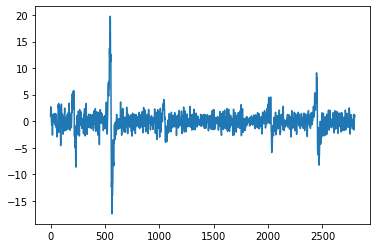

In [90]:
plt.plot(np.diff(df.savgol,n=1))

In [91]:
file = files[0]
fname = os.path.join(dirname, file)

data = parser.parse(fname=fname)
df = pd.DataFrame(data)

file = files[10]
fname = os.path.join(dirname, file)

data = parser.parse(fname=fname)
df_1 = pd.DataFrame(data)

<AxesSubplot:xlabel='0', ylabel='1'>

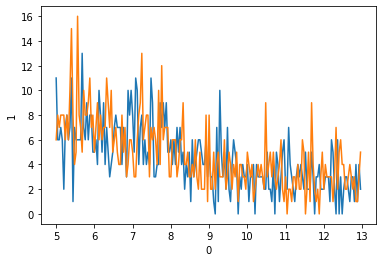

In [32]:
sns.lineplot(x=0, y=1, data=df.iloc[:200, :])
sns.lineplot(x=0, y=2, data=df.iloc[:200, :])

## 

-----

 * 1.
 * 2. 

## End

In [33]:
import tslearn

In [34]:
from tslearn import preprocessing

In [1]:
import os
import itertools
import random

import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42

print(np.__version__)
print(sklearn.__version__)

1.22.4
1.1.3


In [2]:
# Downloading datasets
save_dir="data/"
if not os.path.exists(save_dir):
      os.makedirs(save_dir)

!wget -O data/test.csv 'https://www.dropbox.com/s/rl0755n11jum3r3/test.csv?dl=1'
!wget -O data/train.csv 'https://www.dropbox.com/s/8xjyxub9wavni4v/train.csv?dl=1'

# Preparing datasets
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

y_train_c_sys = train_data['crystal_system']
y_test_c_sys = test_data['crystal_system']
y_train_sgr = train_data['sg_num']
y_test_sgr = test_data['sg_num']

X_train = train_data[[str(i) for i in range(1, 11)] + ['peaknum']]
X_test = test_data[[str(i) for i in range(1, 11)] + ['peaknum']]

classnames = ['Triclinic', 'Monoclinic', 'Orthorhombic', 'Tetragonal', 'Trigonal', 'Hexagonal', 'Cubic']
sgr_nums = np.array(list(set(y_train_sgr)))

--2023-02-20 22:22:48--  https://www.dropbox.com/s/rl0755n11jum3r3/test.csv?dl=1
Распознаётся www.dropbox.com (www.dropbox.com)… 162.125.70.18
Подключение к www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: /s/dl/rl0755n11jum3r3/test.csv [переход]
--2023-02-20 22:22:48--  https://www.dropbox.com/s/dl/rl0755n11jum3r3/test.csv
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://uc403127cd8b11a9e11d178a198c.dl.dropboxusercontent.com/cd/0/get/B21b2gbKsJ8svy5xU3bWFYlIIyxXb1I7ZM92zAIHyU_3-PaFAGc3fpIBTXuN2D-RmmMae7nQT4kNrutkkhrwlo9HwtAJTglSnrphJsUAXMtuJ2x_0ZumbpInExc8RSCbJaYEGdsHtI-tO6tPrpA5c4Iozx5Mg1qx41LL5nG9V_PWo6jCiyMdbe5bZY7Y2KQSJO8/file?dl=1# [переход]
--2023-02-20 22:22:49--  https://uc403127cd8b11a9e11d178a198c.dl.dropboxusercontent.com/cd/0/get/B21b2gbKsJ8svy5xU3bWFYlIIyxXb1I7ZM92zAIHyU_3-PaFAGc3fpIBTXuN2D-RmmMae7nQT4kNrutkkhrwl

In [3]:
# Training crystal system classifier
# This may take couple of minutes.
exrt_crystal_system = ExtraTreesClassifier(n_estimators=500, 
                            max_depth=30, 
                            max_features=9, 
                            n_jobs=-1, 
                            random_state=random_state,
                            warm_start=False)
exrt_crystal_system.fit(X_train, y_train_c_sys)

# validation
y_pred = exrt_crystal_system.predict(X_test)
print('mean accuracy of crystal system prediction: ', metrics.accuracy_score(y_test_c_sys, y_pred)*100)

     

mean accuracy of crystal system prediction:  92.23539116089259


In [6]:
train_data

,1,2,3,4,5,6,7,8,9,10,...,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,q_9,q_10
0,12.800197,14.940639,17.394581,18.505399,18.670426,20.689381,20.721964,21.964808,23.583201,23.846828,...,0.908513,1.059634,1.232431,1.310470,1.322053,1.463536,1.465816,1.552683,1.665523,1.683873
1,16.166407,16.435808,20.174793,22.512152,23.360235,24.111671,25.403932,25.975734,26.334719,28.176936,...,1.146014,1.164981,1.427516,1.590881,1.649996,1.702299,1.792073,1.831724,1.856594,1.983930
2,14.330435,15.183582,16.201044,19.282158,20.098901,23.758891,23.918898,25.133432,25.831712,27.093006,...,1.016587,1.076764,1.148453,1.364967,1.422202,1.677753,1.688888,1.773300,1.821741,1.909068
3,8.402510,15.542676,16.850628,18.598695,20.147478,20.727534,21.372799,24.718322,25.392239,25.669955,...,0.597087,1.102075,1.194174,1.317019,1.425604,1.466205,1.511327,1.744471,1.791261,1.810526
4,12.409748,12.896543,14.923789,14.988381,16.557540,17.135276,17.988328,19.821608,19.853406,20.744413,...,0.880910,0.915322,1.058446,1.063001,1.173550,1.214197,1.274159,1.402778,1.405006,1.467386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123490,4.252578,6.524910,7.675210,7.904897,7.917210,8.099011,8.511026,8.710852,8.775068,9.261263,...,0.302392,0.463829,0.545486,0.561784,0.562658,0.575557,0.604784,0.618957,0.623511,0.657984
123491,12.370783,14.227841,14.250853,14.402265,15.956775,17.596024,20.189999,20.298278,20.314587,21.456334,...,0.878155,1.009347,1.010971,1.021656,1.131250,1.246592,1.428581,1.436162,1.437304,1.517165
123492,12.441538,13.053416,15.960236,17.284801,17.836629,18.298043,18.599645,19.158797,20.741634,24.022378,...,0.883158,0.926408,1.131494,1.224713,1.263501,1.295912,1.317086,1.356316,1.467192,1.696088
123493,11.774650,13.118463,14.664374,14.867687,15.526205,16.282269,16.787787,18.945258,21.943822,22.143109,...,0.835991,0.931005,1.040149,1.054489,1.100915,1.154172,1.189753,1.341338,1.551217,1.565130


In [ ]:


# Training space group classifier
# This may take couple of minutes.

# To reduce the training time, we set n_estimators=50 which smaller than the article.
# The resulted performance is sligly worse than the original (accuracy 80.46% -> 80.20%).
# If you would like to reproduce the result in the article, please set n_estimators=200.
exrt_sgr = ExtraTreesClassifier(n_estimators=50, n_jobs=-1, max_depth=25, max_features=None, random_state=random_state)
exrt_sgr.fit(X_train, y_train_sgr)

# validation
y_pred = exrt_sgr.predict(X_test)
print('mean accuracy of space group prediction: ', metrics.accuracy_score(y_test_sgr, y_pred)*100)

     


In [ ]:
# saveing prediction results (if needed)
test_pred = pd.DataFrame()
test_pred['crystal_system_pred'] = exrt_crystal_system.predict(X_test)
test_pred['sg_num_pred'] = exrt_sgr.predict(X_test)
test_pred['sg_num_true'] = test_data['sg_num']
test_pred['crystal_system_true'] = test_data['crystal_system']

test_pred.to_csv('pred_result_test.csv', index=False)
     

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(y_test_sgr, y_pred)
cnf_matrix_norm = cnf_matrix / cnf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,4), dpi=100)
plt.imshow(cnf_matrix_norm, cmap=plt.cm.Blues)
plt.colorbar()